# Report

## Imports

In [1]:
import numpy as np
import cv2 as cv

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Preprocessing

In [2]:
# download the data
! kaggle competitions download -c iapr24-coin-counter
! unzip iapr24-coin-counter.zip && rm iapr24-coin-counter.zip

# clear the output for cleaner notebook
clear_output()

## Hough Transform

In [3]:
img_path = 'train/1. neutral_bg/L1010277.JPG'

ref_chf_path = 'ref/ref_chf.JPG'
ref_eur_path = 'ref/ref_eur.JPG'

In [4]:
def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv.resize(image, dim, interpolation=cv.INTER_AREA)
    return resized

In [5]:
img = cv.imread(ref_chf_path, cv.IMREAD_GRAYSCALE)
img_resized = resize_image(img, 10)

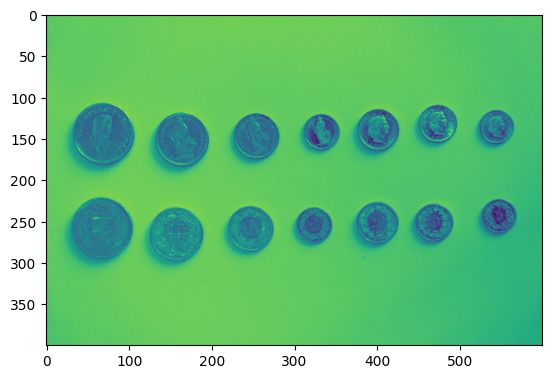

In [6]:
plt.imshow(img_resized)

In [7]:
img_blurred = cv.medianBlur(img_resized, 5)
cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)

circles = cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50)

In [8]:
circles

array([[[ 68.5, 145.5,  37.3],
        [400.5, 252.5,  25.8],
        [162.5, 152.5,  33.5],
        [253.5, 147.5,  27.8],
        [ 66.5, 257.5,  36.2],
        [246.5, 260.5,  27.9],
        [401.5, 140.5,  25.8],
        [156.5, 264.5,  31.6],
        [545.5, 245.5,  22.4],
        [544.5, 139.5,  23.1],
        [323.5, 256.5,  21.8],
        [332.5, 143.5,  21.8],
        [473.5, 131.5,  22.3],
        [472.5, 251.5,  20.2]]], dtype=float32)

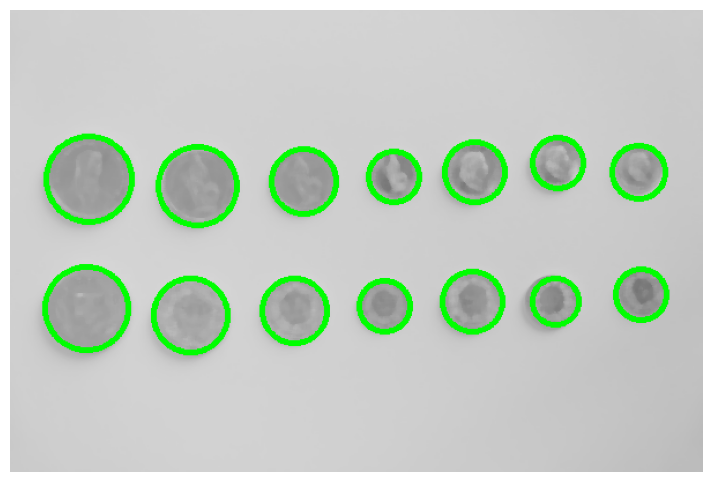

In [9]:
circles = np.uint16(np.around(circles))

for (x, y, r) in circles[0, :]:
        cv.circle(cimg, (x, y), r, (0, 255, 0), 4)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(cimg)
plt.axis('off')  # Hide the axis
plt.show()

In [10]:
# Ordering circles by radius
c = circles[0]
sorted_index = np.argsort(c[:, -1])
circles_sorted = c[sorted_index]

# finding max/min radii to provide better estimation in Hough transform
max_rad = np.max(circles_sorted[:, -1])
min_rad = np.min(circles_sorted[:, -1])
print(f"Max rad : {max_rad}\tMin rad : {min_rad}")


Max rad : 37	Min rad : 20


## Finding radii distribution

In [16]:
# Iterating on each img
import os

min_rad = 15
max_rad = 42

circles = []
circles_prior = []

test_dir_path = 'test'
detect_dir_path = 'detect'

for filename in os.listdir(test_dir_path):
	filepath = os.path.join(test_dir_path, filename)
	
	if os.path.isfile(filepath):
		
		# Open img and resize
		img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
		img_resized = resize_image(img, 10)
		img_blurred = cv.medianBlur(img_resized, 5)
		cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)

		# Find circles with and without educated radii guess
		circles.append(cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50))
		c_prior = cv.HoughCircles(image=img_blurred, circles=cv.HOUGH_GRADIENT, method=1,  dp=20, minDist=min_rad, param1=70, param2=20, minRadius=min_rad, maxRadius=max_rad)
		circles_prior.append(c_prior)

		# Show circles on image and save
		c_prior_int = np.uint16(np.around(c_prior))

		for (x, y, r) in c_prior_int[0, :]:
			cv.imwrite(os.path.join(detect_dir_path, filename), cv.circle(cimg, (x, y), r, (0, 255, 0), 4))


		print(f"Done with {filename}")

#circles = cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\hough.cpp:2338: error: (-5:Bad argument) Unrecognized method id. Actually supported methods are HOUGH_GRADIENT and HOUGH_GRADIENT_ALT in function 'cv::HoughCircles'


In [12]:
radius_list = np.array([arr[0, -1, -1] for arr in circles])
radius_list_prior = np.array([arr[0, -1, -1] for arr in circles_prior])

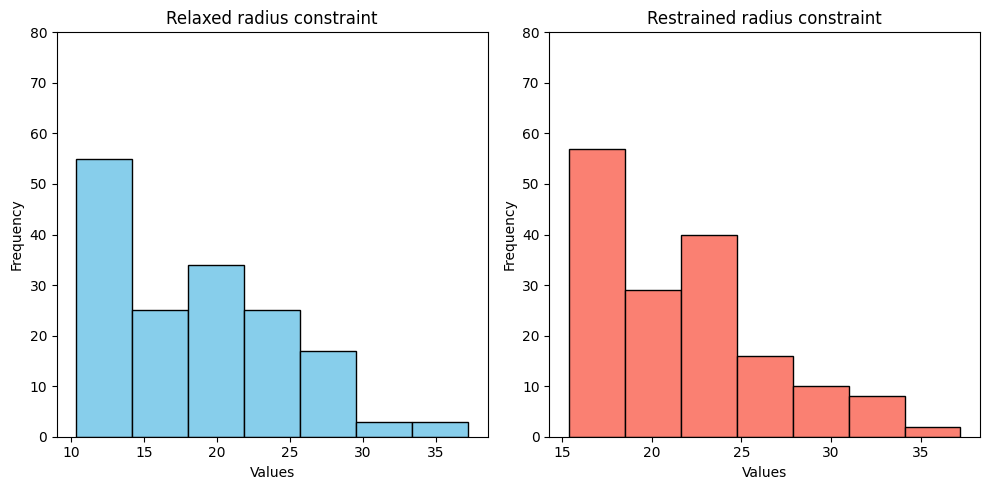

In [13]:
import matplotlib.pyplot as plt

# bins
bin_size = 7

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram for source 1
axes[0].hist(radius_list, bins=bin_size, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Relaxed radius constraint')
axes[0].set_ylim([0, 80])

# Plot histogram for source 2
axes[1].hist(radius_list_prior, bins=bin_size, color='salmon', edgecolor='black')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Restrained radius constraint')
axes[1].set_ylim([0, 80])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [14]:
from scipy import stats
modes = stats.mode(radius_list_prior)

In [15]:
modes.count

10